### Implementation Outline
- Preprocessing:

Data cleaning and feature engineering.
Calculation of OFI.
- Modeling (VAR):

Fit a VAR model on historical buy/sell orders.
Predict future buy/sell orders using the VAR model.
- Modeling (Neural Network):

Calculate residuals between actual OFI and VAR-predicted OFI.
Train a neural network on these residuals.
- UDE Combination:

Combine VAR predictions and neural network-predicted residuals to get final OFI predictions.
- Testing and Evaluation:

Test the UDE model on the continuation data and evaluate the performance.

In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = 'train10000_syn.csv'  # Change this to the correct file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df['Time'] = pd.to_datetime(df['Time'])

# Set the 'Time' column as the index
df.set_index('Time', inplace=True)

# Filter for BUY and SELL orders
buy_orders = df['buy_orders']
sell_orders = df['sell_orders']


In [3]:
df

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:48,38,21
2024-10-14 07:53:49,51,22
2024-10-14 07:53:50,28,11
2024-10-14 07:53:51,14,9
2024-10-14 07:53:52,42,33
...,...,...
2024-10-14 10:40:23,14,1
2024-10-14 10:40:24,26,34
2024-10-14 10:40:25,3,8


In [4]:
order_counts=df

In [6]:
# Calculate OFI, avoid division by zero
order_counts['OFI'] = (order_counts['buy_orders'] - order_counts['sell_orders']) / (order_counts['buy_orders'] + order_counts['sell_orders'])

# Fill any NaN values (in case of zero division) with 0
order_counts['OFI'].fillna(0, inplace=True)

# Display the calculated OFI values
print(order_counts.head())


                     buy_orders  sell_orders       OFI
Time                                                  
2024-10-14 07:53:48          38           21  0.288136
2024-10-14 07:53:49          51           22  0.397260
2024-10-14 07:53:50          28           11  0.435897
2024-10-14 07:53:51          14            9  0.217391
2024-10-14 07:53:52          42           33  0.120000


C:\Users\user\AppData\Local\Temp\ipykernel_19004\3576943439.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts['OFI'].fillna(0, inplace=True)


In [7]:
order_counts

,buy_orders,sell_orders,OFI
Time,,,
2024-10-14 07:53:48,38,21,0.288136
2024-10-14 07:53:49,51,22,0.397260
2024-10-14 07:53:50,28,11,0.435897
2024-10-14 07:53:51,14,9,0.217391
2024-10-14 07:53:52,42,33,0.120000
...,...,...,...
2024-10-14 10:40:23,14,1,0.866667
2024-10-14 10:40:24,26,34,-0.133333
2024-10-14 10:40:25,3,8,-0.454545


VAR implementation

In [8]:
# Prepare the data for the VAR model by selecting buy_orders and sell_orders
var_data = order_counts[['buy_orders', 'sell_orders']]

# Check for any missing values and fill with 0 if necessary
var_data = var_data.fillna(0)

# Display the first few rows to ensure the data is ready
print(var_data.head())


                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:48          38           21
2024-10-14 07:53:49          51           22
2024-10-14 07:53:50          28           11
2024-10-14 07:53:51          14            9
2024-10-14 07:53:52          42           33


In [9]:
from statsmodels.tsa.api import VAR

# Fit the VAR model
model = VAR(var_data)

# Select the optimal lag length using criteria like AIC, BIC, etc.
lag_order = 2

# Fit the VAR model with this lag order
var_model = model.fit(lag_order)

# Print the model summary to ensure it is fitted correctly
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     15:18:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.4739
Nobs:                     9998.00    HQIC:                   11.4692
Log likelihood:          -85685.2    FPE:                    95484.3
AIC:                      11.4667    Det(Omega_mle):         95388.9
--------------------------------------------------------------------
Results for equation buy_orders
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 29.357486         0.625923           46.903           0.000
L1.buy_orders          0.003770         0.010001            0.377           0.706
L1.sell_orders         0.011110         0.010021   

c:\Users\user\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)


In [10]:
# Forecast future values (e.g., the next 10 steps)
forecast_steps = 10
var_forecast = var_model.forecast(var_data.values[-lag_order:], steps=forecast_steps)

# Convert the forecast to a DataFrame for easier handling
forecast_df = pd.DataFrame(var_forecast, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted values
print(forecast_df)



   buy_orders_forecast  sell_orders_forecast
0            30.852112             30.072363
1            30.630174             29.942942
2            30.292972             29.860252
3            30.288732             29.863403
4            30.287547             29.866268
5            30.287629             29.866322
6            30.287679             29.866342
7            30.287680             29.866341
8            30.287681             29.866341
9            30.287681             29.866341


In [11]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of buy_orders and sell_orders
result_buy = adfuller(var_data['buy_orders'])
result_sell = adfuller(var_data['sell_orders'])

print('Buy Orders ADF Statistic:', result_buy[0])
print('Buy Orders p-value:', result_buy[1])
print('Sell Orders ADF Statistic:', result_sell[0])
print('Sell Orders p-value:', result_sell[1])


Buy Orders ADF Statistic: -99.58655976423736
Buy Orders p-value: 0.0
Sell Orders ADF Statistic: -100.01597378502306
Sell Orders p-value: 0.0


In [12]:
lag_order = 2

# Fit the VAR model with this lag order
var_model = model.fit(lag_order)
var_forecast = var_model.forecast(var_data.values[-lag_order:], steps=forecast_steps)

# Convert the forecast to a DataFrame for easier handling
forecast_df = pd.DataFrame(var_forecast, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted values
print(forecast_df)


   buy_orders_forecast  sell_orders_forecast
0            30.852112             30.072363
1            30.630174             29.942942
2            30.292972             29.860252
3            30.288732             29.863403
4            30.287547             29.866268
5            30.287629             29.866322
6            30.287679             29.866342
7            30.287680             29.866341
8            30.287681             29.866341
9            30.287681             29.866341


In [13]:
var_model.fittedvalues

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:50,30.125644,29.676956
2024-10-14 07:53:51,29.926503,29.666334
2024-10-14 07:53:52,29.679536,29.905453
2024-10-14 07:53:53,30.025736,29.894348
2024-10-14 07:53:54,30.380918,29.866223
...,...,...
2024-10-14 10:40:23,29.822775,29.713562
2024-10-14 10:40:24,29.984671,30.133898
2024-10-14 10:40:25,29.842473,29.938009


In [14]:
var_data[['buy_orders', 'sell_orders']]

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:48,38,21
2024-10-14 07:53:49,51,22
2024-10-14 07:53:50,28,11
2024-10-14 07:53:51,14,9
2024-10-14 07:53:52,42,33
...,...,...
2024-10-14 10:40:23,14,1
2024-10-14 10:40:24,26,34
2024-10-14 10:40:25,3,8


Align it to same start time

In [15]:
# Align var_data with the fitted values by dropping the initial rows (based on lag order)
fitted_values = var_model.fittedvalues
aligned_var_data = var_data.iloc[len(var_data) - len(fitted_values):]  # Aligning the lengths

# Calculate residuals between the actual data and the VAR model's fitted values
residuals = aligned_var_data[['buy_orders', 'sell_orders']] - fitted_values

# Fill any missing residuals (if any) with 0
residuals.fillna(0, inplace=True)

# Display the aligned data and residuals
print("Aligned VAR Data:")
print(aligned_var_data.head())
print("Residuals:")
print(residuals.head())


Aligned VAR Data:
                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:50          28           11
2024-10-14 07:53:51          14            9
2024-10-14 07:53:52          42           33
2024-10-14 07:53:53           7           42
2024-10-14 07:53:54          60            9
Residuals:
                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:50   -2.125644   -18.676956
2024-10-14 07:53:51  -15.926503   -20.666334
2024-10-14 07:53:52   12.320464     3.094547
2024-10-14 07:53:53  -23.025736    12.105652
2024-10-14 07:53:54   29.619082   -20.866223


In [16]:
residuals

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:50,-2.125644,-18.676956
2024-10-14 07:53:51,-15.926503,-20.666334
2024-10-14 07:53:52,12.320464,3.094547
2024-10-14 07:53:53,-23.025736,12.105652
2024-10-14 07:53:54,29.619082,-20.866223
...,...,...
2024-10-14 10:40:23,-15.822775,-28.713562
2024-10-14 10:40:24,-3.984671,3.866102
2024-10-14 10:40:25,-26.842473,-21.938009


Fit NN for residuals

In [17]:
X = aligned_var_data[['buy_orders', 'sell_orders']]  # Use the original aligned buy/sell orders as features
y = residuals[['buy_orders', 'sell_orders']]

In [18]:
X, y

(                     buy_orders  sell_orders
 Time                                        
 2024-10-14 07:53:50          28           11
 2024-10-14 07:53:51          14            9
 2024-10-14 07:53:52          42           33
 2024-10-14 07:53:53           7           42
 2024-10-14 07:53:54          60            9
 ...                         ...          ...
 2024-10-14 10:40:23          14            1
 2024-10-14 10:40:24          26           34
 2024-10-14 10:40:25           3            8
 2024-10-14 10:40:26          15           50
 2024-10-14 10:40:27          29           50
 
 [9998 rows x 2 columns],
                      buy_orders  sell_orders
 Time                                        
 2024-10-14 07:53:50   -2.125644   -18.676956
 2024-10-14 07:53:51  -15.926503   -20.666334
 2024-10-14 07:53:52   12.320464     3.094547
 2024-10-14 07:53:53  -23.025736    12.105652
 2024-10-14 07:53:54   29.619082   -20.866223
 ...                         ...          ...
 2024-

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display the sizes of training and testing data
print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 7998
Testing data size: 2000


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network architecture
model_nn = Sequential()

# Input layer with two input features (buy_orders, sell_orders)
model_nn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(Dense(16, activation='relu'))  # Hidden layer
model_nn.add(Dense(2))  # Output layer (2 neurons for buy_orders and sell_orders residuals)

# Compile the model with mean squared error loss
model_nn.compile(optimizer='adam', loss='mean_squared_error')
# model_nn.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model again
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))

# Train the model (reduce the number of epochs due to small dataset)
#history = model_nn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the neural network with early stopping
history = model_nn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 123.4966 - val_loss: 62.3637
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 39.6355 - val_loss: 0.7264
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6162 - val_loss: 0.6002
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4215 - val_loss: 0.4069
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3781 - val_loss: 0.2414
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3472 - val_loss: 0.5454
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2927 - val_loss: 0.1729
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2213 - val_loss: 0.3728
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2895 - val_loss: 0.1459
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2711 - val_loss: 0.1471
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1856 - val_loss: 0.1718
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━

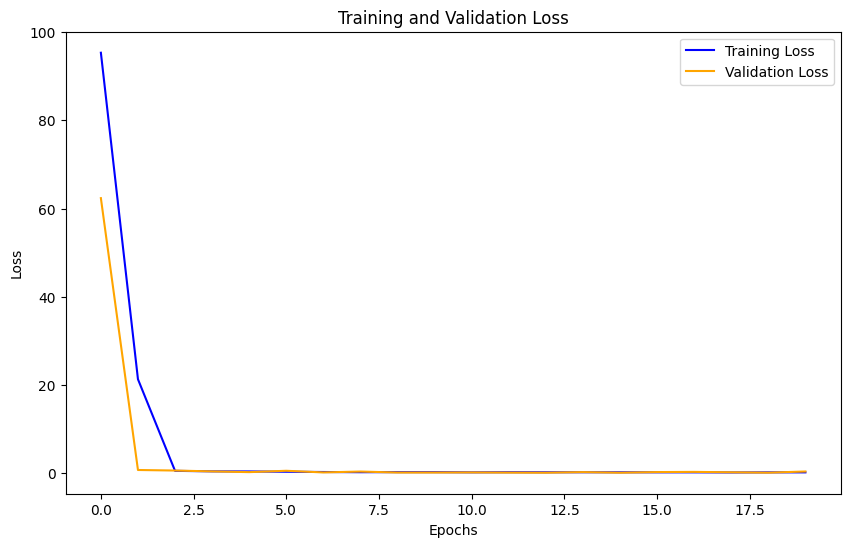

In [23]:
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plot
plt.show()


In [24]:
# Evaluate the model on the test data
test_loss = model_nn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict residuals for the test set
predicted_residuals = model_nn.predict(X_test)

# Display the predicted residuals
print(predicted_residuals[:5])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1036  
Test Loss: 0.10646145790815353
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
[[ -5.275525    8.2397785]
 [ -8.28434   -20.88636  ]
 [ 11.847743   -9.704077 ]
 [-18.397802   24.074493 ]
 [ -3.295061   21.220184 ]]


In [88]:
# from sklearn.preprocessing import MinMaxScaler

# # Normalize the input features (buy_orders, sell_orders) to be in the range [0, 1]
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
# # Train the neural network on the scaled data
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))


In [89]:
# Define a simpler neural network architecture with dropout to avoid overfitting
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# model_nn = Sequential()
# model_nn.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)))  # Single hidden layer
# model_nn.add(Dense(2))  # Output layer

# # Compile the model
# model_nn.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model again
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Early stopping to stop training when validation loss stops improving
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the neural network with early stopping
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])


In [25]:
# Evaluate the model on the test data
test_loss = model_nn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict residuals for the test set
predicted_residuals = model_nn.predict(X_test)

# Display the predicted residuals
print(predicted_residuals[:5])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.1036
Test Loss: 0.10646145790815353
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ -5.275525    8.2397785]
 [ -8.28434   -20.88636  ]
 [ 11.847743   -9.704077 ]
 [-18.397802   24.074493 ]
 [ -3.295061   21.220184 ]]


In [26]:
# Get the VAR predictions for the test set
var_forecast_test = var_model.forecast(X_test.values, steps=len(X_test))

# Combine VAR predictions and predicted residuals
final_forecast = var_forecast_test + predicted_residuals

# Display the final forecast (buy_orders and sell_orders predictions with residuals)
print(final_forecast[:5])


[[25.57658705 38.31214151]
 [22.34583453  9.05658215]
 [42.14071481 20.15617571]
 [11.89093012 53.93789688]
 [26.99248592 51.08645262]]


In [29]:
# Calculate the actual OFI for the test data
actual_ofi = (X_test['buy_orders'] - X_test['sell_orders']) / (X_test['buy_orders'] + X_test['sell_orders'])
actual_ofi.fillna(0, inplace=True)  # Handle any NaN values (e.g., when both buy and sell orders are zero)

# Display the actual OFI values
print(actual_ofi.head())


Time
2024-10-14 10:07:08   -0.206349
2024-10-14 10:07:09    0.419355
2024-10-14 10:07:10    0.354839
2024-10-14 10:07:11   -0.636364
2024-10-14 10:07:12   -0.307692
dtype: float64


In [30]:
# Combine VAR predictions and neural network residuals
final_ofi_predictions = (final_forecast[:, 0] - final_forecast[:, 1]) / (final_forecast[:, 0] + final_forecast[:, 1])

# Display the predicted OFI values
print(final_ofi_predictions[:5])


[-0.19933961  0.42319203  0.35289946 -0.63873182 -0.30858471]


Compare final ofi predictions and actual ofi head

In [186]:
final_ofi_predictions

array([-0.20084942,  0.41645815,  0.35221395, ..., -0.45406602,
       -0.54385736, -0.26898682])

In [31]:
print((actual_ofi, final_ofi_predictions))

(Time
2024-10-14 10:07:08   -0.206349
2024-10-14 10:07:09    0.419355
2024-10-14 10:07:10    0.354839
2024-10-14 10:07:11   -0.636364
2024-10-14 10:07:12   -0.307692
                         ...   
2024-10-14 10:40:23    0.866667
2024-10-14 10:40:24   -0.133333
2024-10-14 10:40:25   -0.454545
2024-10-14 10:40:26   -0.538462
2024-10-14 10:40:27   -0.265823
Length: 2000, dtype: float64, array([-0.19933961,  0.42319203,  0.35289946, ..., -0.46125336,
       -0.54024181, -0.26669724]))


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(actual_ofi, final_ofi_predictions)
mae = mean_absolute_error(actual_ofi, final_ofi_predictions)
r2 = r2_score(actual_ofi, final_ofi_predictions)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')


Mean Squared Error (MSE): 0.00045689055170208327
Mean Absolute Error (MAE): 0.00492334658121669
R-squared: 0.9980640976371983


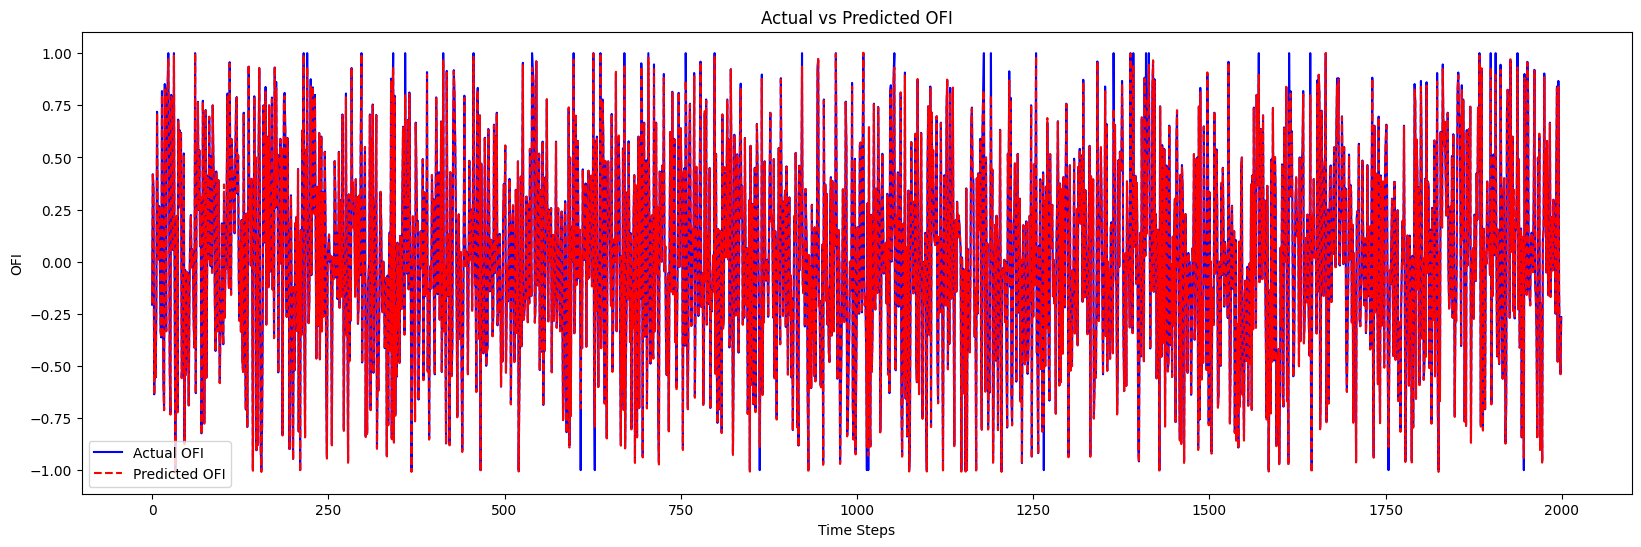

In [34]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted OFI
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi.values, label='Actual OFI', color='blue')
plt.plot(final_ofi_predictions, label='Predicted OFI', color='red', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('Actual vs Predicted OFI')
plt.legend()
plt.show()

Model testing 

In [36]:
# Load the continuation data from '75000_trades_25.csv'
continuation_file_path = 'test3000_syn.csv'
continuation_data = pd.read_csv(continuation_file_path)

# Convert 'Time' column to datetime format and set as index
continuation_data['Time'] = pd.to_datetime(continuation_data['Time'])
continuation_data.set_index('Time', inplace=True)

order_counts_cont=continuation_data

# Display the first few rows of the continuation data
print(order_counts_cont.head())


                     buy_orders  sell_orders
Time                                        
2024-10-14 10:40:28          43           48
2024-10-14 10:40:29          29           17
2024-10-14 10:40:30          35           42
2024-10-14 10:40:31           2           11
2024-10-14 10:40:32          21            2


In [37]:
order_counts_cont['OFI'] = (order_counts_cont['buy_orders'] - order_counts_cont['sell_orders']) / (order_counts_cont['buy_orders'] + order_counts_cont['sell_orders'])
order_counts_cont['OFI'].fillna(0, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_19004\724105446.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts_cont['OFI'].fillna(0, inplace=True)


In [38]:
print(order_counts_cont.head())

                     buy_orders  sell_orders       OFI
Time                                                  
2024-10-14 10:40:28          43           48 -0.054945
2024-10-14 10:40:29          29           17  0.260870
2024-10-14 10:40:30          35           42 -0.090909
2024-10-14 10:40:31           2           11 -0.692308
2024-10-14 10:40:32          21            2  0.826087


In [40]:
# Prepare the continuation data for the VAR model
var_cont_data = order_counts_cont[['buy_orders', 'sell_orders']].fillna(0)

# Use the trained VAR model to forecast buy and sell orders
var_forecast_cont = var_model.forecast(var_cont_data.values[:len(X_test)], steps=len(var_cont_data))

# Convert the VAR forecast to a DataFrame
var_forecast_df_cont = pd.DataFrame(var_forecast_cont, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted buy and sell orders for the continuation data
print(var_forecast_df_cont.head())


   buy_orders_forecast  sell_orders_forecast
0            30.254206             30.027746
1            29.907499             29.527401
2            30.285204             29.869017
3            30.282226             29.868740
4            30.287733             29.866396


In [41]:
# Normalize the continuation data using the same scaler used for the training data
# var_cont_scaled = scaler.transform(var_cont_data)


# Predict residuals using the neural network
# predicted_residuals_cont = model_nn.predict(var_cont_scaled)

predicted_residuals_cont = model_nn.predict(var_cont_data)

# Display the predicted residuals
print(predicted_residuals_cont[:5])


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
[[ 12.805122   18.301823 ]
 [ -1.131879  -12.775938 ]
 [  4.7621717  12.270206 ]
 [-28.354687  -18.891584 ]
 [ -9.260257  -27.62589  ]]


In [42]:
# Combine VAR predictions and neural network residuals for final OFI forecast
final_forecast_cont = var_forecast_cont + predicted_residuals_cont

# Calculate the final OFI predictions for the continuation data
final_ofi_predictions_cont = (final_forecast_cont[:, 0] - final_forecast_cont[:, 1]) / (final_forecast_cont[:, 0] + final_forecast_cont[:, 1])
final_ofi_predictions_cont = pd.Series(final_ofi_predictions_cont).fillna(0)  # Handle any NaN values

# Display the final OFI predictions for the continuation data
print(final_ofi_predictions_cont.head())


0   -0.057668
1    0.264110
2   -0.091879
3   -0.701265
4    0.807417
dtype: float64


In [43]:
# Calculate OFI predictions using only the VAR model for the continuation data
var_ofi_predictions_cont = (var_forecast_df_cont['buy_orders_forecast'] - var_forecast_df_cont['sell_orders_forecast']) / (var_forecast_df_cont['buy_orders_forecast'] + var_forecast_df_cont['sell_orders_forecast'])
var_ofi_predictions_cont.fillna(0, inplace=True)

# Compare VAR-only OFI with actual OFI from continuation data
actual_ofi_cont = order_counts_cont['OFI']

# Calculate evaluation metrics for the VAR-only model
mse_var = mean_squared_error(actual_ofi_cont, var_ofi_predictions_cont)
mae_var = mean_absolute_error(actual_ofi_cont, var_ofi_predictions_cont)
r2_var = r2_score(actual_ofi_cont, var_ofi_predictions_cont)

print(f'VAR-only Model - MSE: {mse_var}, MAE: {mae_var}, R-squared: {r2_var}')


VAR-only Model - MSE: 0.24705557880027376, MAE: 0.40351748221638645, R-squared: -5.667134502274074e-05


In [44]:
# Calculate evaluation metrics for the combined model
mse_combined = mean_squared_error(actual_ofi_cont, final_ofi_predictions_cont)
mae_combined = mean_absolute_error(actual_ofi_cont, final_ofi_predictions_cont)
r2_combined = r2_score(actual_ofi_cont, final_ofi_predictions_cont)

print(f'Combined VAR + Neural Network Model - MSE: {mse_combined}, MAE: {mae_combined}, R-squared: {r2_combined}')


Combined VAR + Neural Network Model - MSE: 0.0008169800108909883, MAE: 0.005625581504879748, R-squared: 0.9966929453112752


In [45]:
var_ofi_predictions_cont.values

array([0.00375668, 0.0063952 , 0.00691868, ..., 0.00700434, 0.00700434,
       0.00700434])

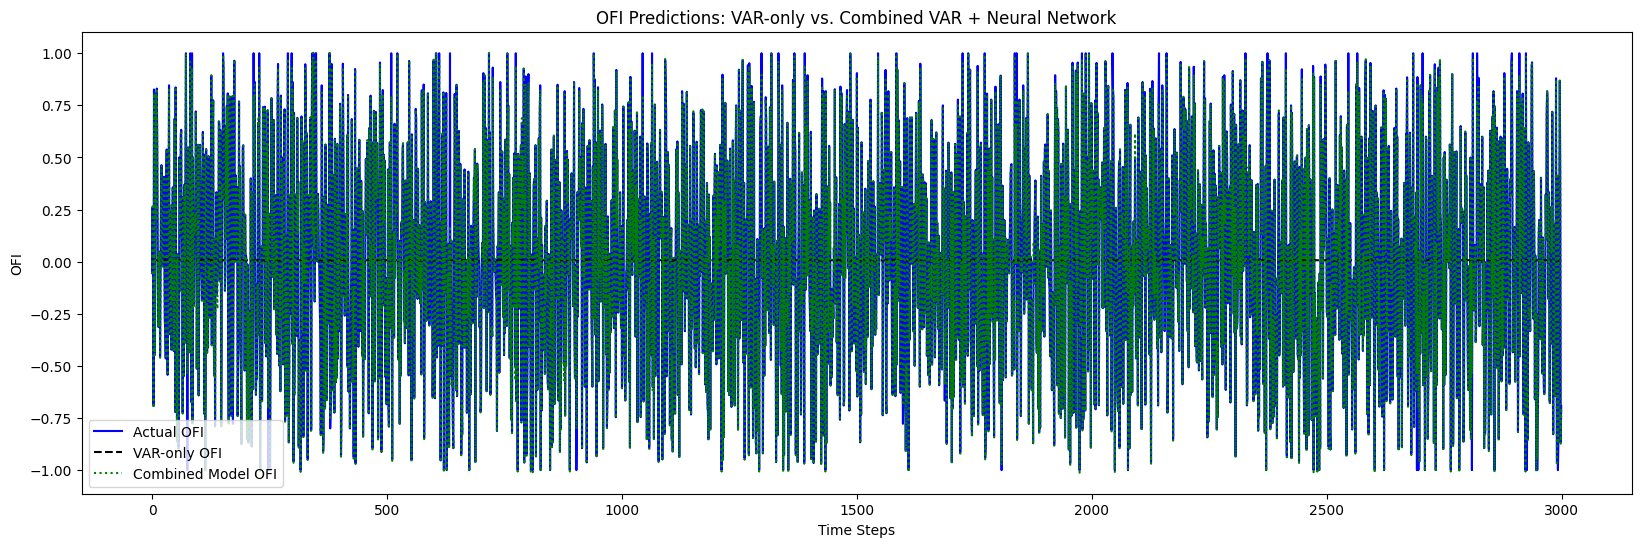

In [46]:
# Plot actual OFI vs predicted OFI from both models
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
plt.plot(final_ofi_predictions_cont.values, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: VAR-only vs. Combined VAR + Neural Network')
plt.legend()
plt.show()


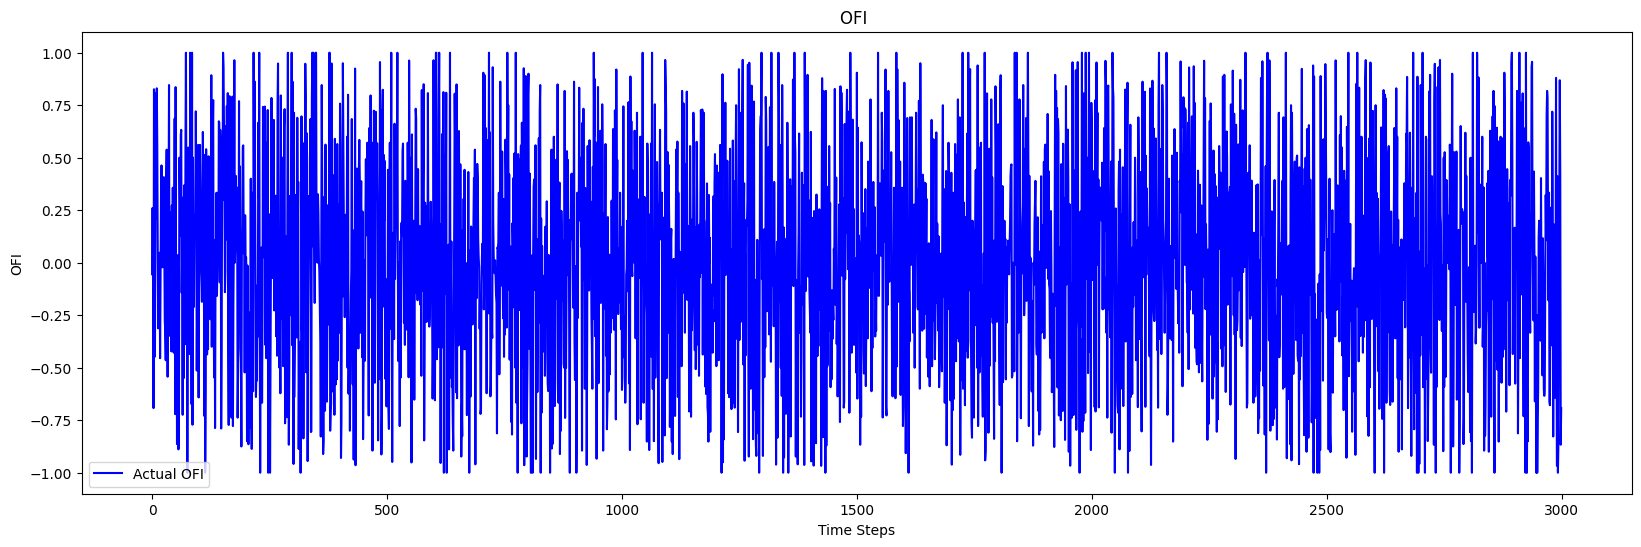

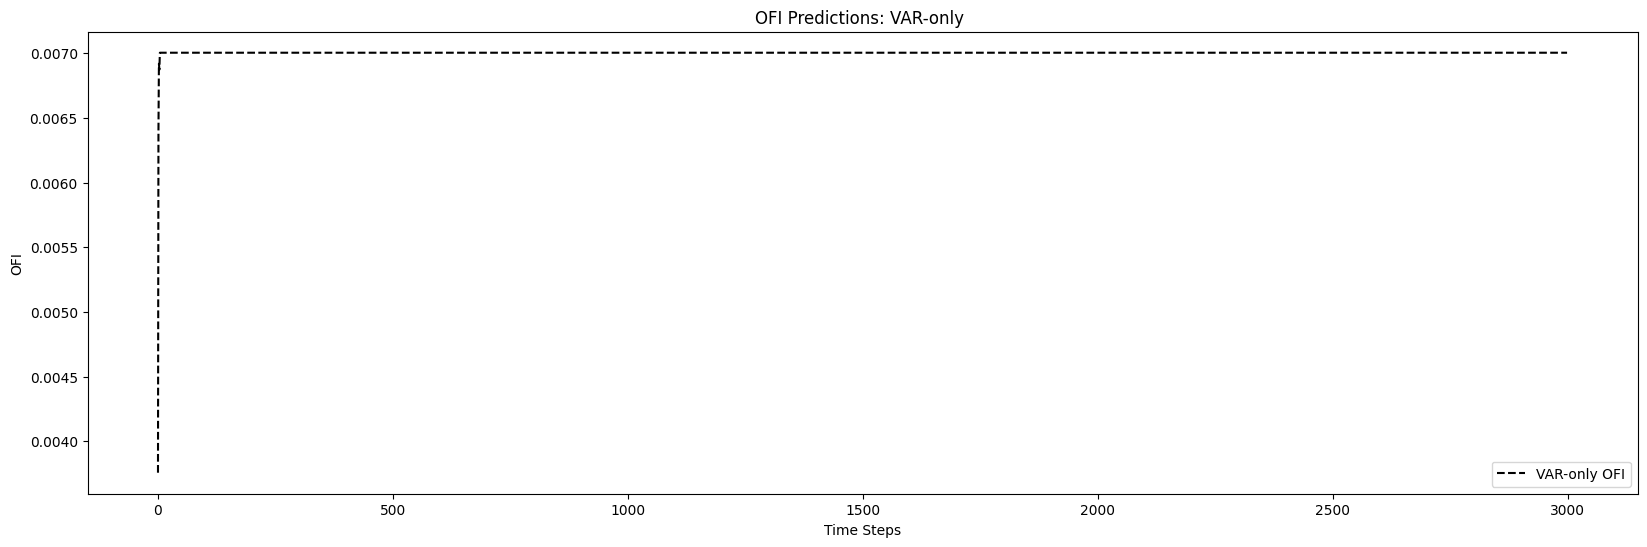

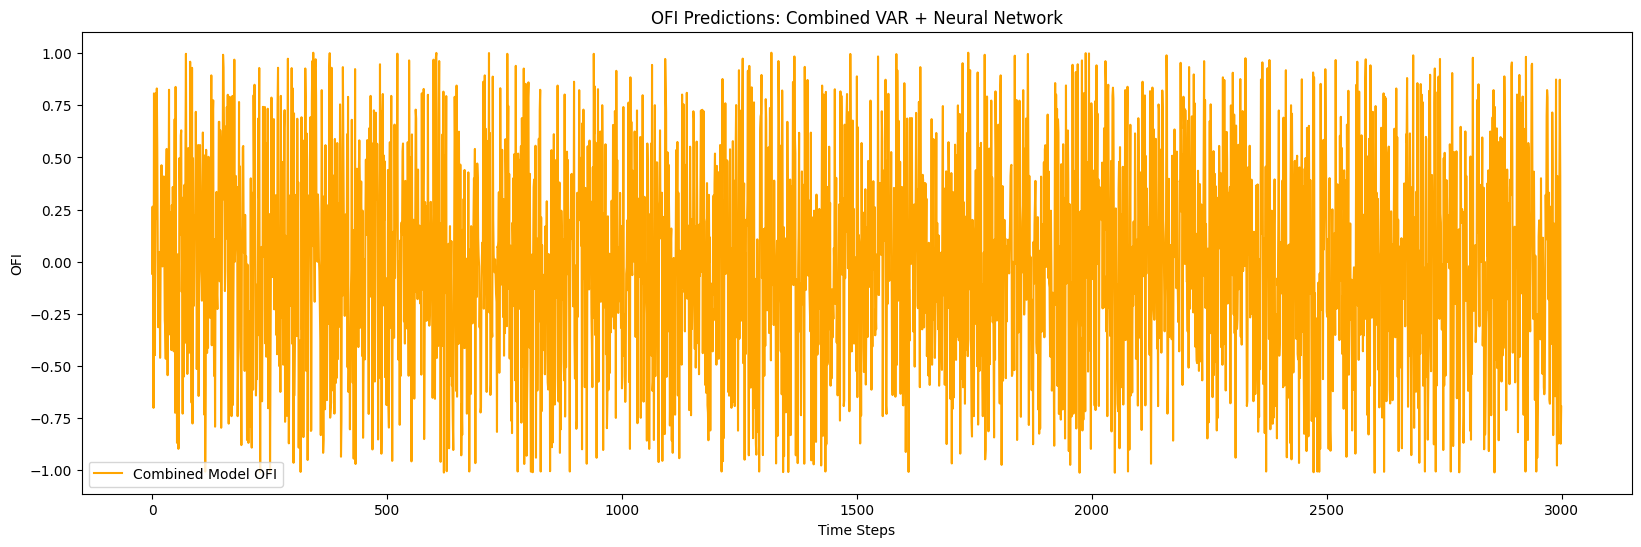

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
# plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
# plt.plot(final_ofi_predictions_cont.values, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI ')
plt.legend()
plt.show()
plt.figure(figsize=(20, 6))
# plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
# plt.plot(final_ofi_predictions_cont.values, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: VAR-only ')
plt.legend()
plt.show()
plt.figure(figsize=(20, 6))
# plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
# plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
plt.plot(final_ofi_predictions_cont.values, label='Combined Model OFI', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: Combined VAR + Neural Network')
plt.legend()
plt.show()

In [51]:
# Combine actual and predicted OFI into a DataFrame
comparison_df = pd.DataFrame({
    'Actual_OFI': actual_ofi_cont.values,
    'VAR_Only_OFI': var_ofi_predictions_cont.values,
    'Combined_Model_OFI': final_ofi_predictions_cont.values
})

# Display the DataFrame
print(comparison_df.head())


   Actual_OFI  VAR_Only_OFI  Combined_Model_OFI
0   -0.054945      0.003757           -0.057668
1    0.260870      0.006395            0.264110
2   -0.090909      0.006919           -0.091879
3   -0.692308      0.006874           -0.701265
4    0.826087      0.007004            0.807417


In [52]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI
0,-0.054945,0.003757,-0.057668
1,0.260870,0.006395,0.264110
2,-0.090909,0.006919,-0.091879
3,-0.692308,0.006874,-0.701265
4,0.826087,0.007004,0.807417
...,...,...,...
2995,0.308642,0.007004,0.305851
2996,0.868852,0.007004,0.873076
2997,0.411765,0.007004,0.412398
2998,-0.866667,0.007004,-0.873167


In [53]:
def ofi_to_signal(ofi):
    if ofi > 0:
        return 'BUY'
    elif ofi < 0:
        return 'SELL'
    else:
        return 'HOLD'

In [54]:
comparison_df['actual_signal'] = comparison_df['Actual_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_VAR_signal'] = comparison_df['VAR_Only_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_UDE_signal'] = comparison_df['Combined_Model_OFI'].apply(ofi_to_signal)


In [55]:
# Convert actual and predicted OFI to binary labels (1 for positive, 0 for negative)
actual_ofi_labels = (actual_ofi_cont > 0).astype(int)
var_ofi_labels = (var_ofi_predictions_cont > 0).astype(int)
combined_ofi_labels = (final_ofi_predictions_cont > 0).astype(int)


In [56]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for VAR-only model and combined model
accuracy_var = accuracy_score(actual_ofi_labels, var_ofi_labels) * 100
accuracy_combined = accuracy_score(actual_ofi_labels, combined_ofi_labels) * 100

print(f'VAR-only Model Accuracy: {accuracy_var:.2f}%')
print(f'Combined UDE Model Accuracy: {accuracy_combined:.2f}%')


VAR-only Model Accuracy: 48.83%
Combined UDE Model Accuracy: 99.87%


In [57]:
from sklearn.metrics import precision_score

# Calculate precision for VAR-only model and combined model
precision_var = precision_score(actual_ofi_labels, var_ofi_labels) * 100
precision_combined = precision_score(actual_ofi_labels, combined_ofi_labels) * 100

print(f'VAR-only Model Precision: {precision_var:.2f}%')
print(f'Combined UDE Model Precision: {precision_combined:.2f}%')


VAR-only Model Precision: 48.83%
Combined UDE Model Precision: 99.73%


In [59]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI,actual_signal,forecasted_VAR_signal,forecasted_UDE_signal
0,-0.054945,0.003757,-0.057668,SELL,BUY,SELL
1,0.260870,0.006395,0.264110,BUY,BUY,BUY
2,-0.090909,0.006919,-0.091879,SELL,BUY,SELL
3,-0.692308,0.006874,-0.701265,SELL,BUY,SELL
4,0.826087,0.007004,0.807417,BUY,BUY,BUY
...,...,...,...,...,...,...
2995,0.308642,0.007004,0.305851,BUY,BUY,BUY
2996,0.868852,0.007004,0.873076,BUY,BUY,BUY
2997,0.411765,0.007004,0.412398,BUY,BUY,BUY
2998,-0.866667,0.007004,-0.873167,SELL,BUY,SELL


In [60]:
comparison_df.to_csv('UDE_comparision_data1.csv')

In [61]:
accuracy_1 = (comparison_df['actual_signal'] == comparison_df['forecasted_VAR_signal']).mean()
print(f"OFI VAR Prediction Accuracy: {accuracy_1 * 100:.2f}%")

accuracy_2 = (comparison_df['actual_signal'] == comparison_df['forecasted_UDE_signal']).mean()
print(f"OFI UDE Prediction Accuracy: {accuracy_2 * 100:.2f}%")

OFI VAR Prediction Accuracy: 48.83%
OFI UDE Prediction Accuracy: 98.27%


In [62]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between 'Actual_OFI' and 'Combined_Model_OFI'
mse = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['Combined_Model_OFI'])
mse2 = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['VAR_Only_OFI'])
print(f"Mean Squared Error on UDE  combined model (MSE): {mse}")
print(f"Mean Squared Error on VAR linear model  (MSE): {mse2}")

Mean Squared Error on UDE  combined model (MSE): 0.0008169800108909883
Mean Squared Error on VAR linear model  (MSE): 0.24705557880027376
